Tenemos una serie de ventas de la web de Kaggle.

Fuente: https://www.kaggle.com/c/demand-forecasting-kernels-only

Son 5 años de datos diarios para ventas de 50 artículos diferentes en 10 negocios distintos, entre 2013 y 2017 inclusive.

Elegiremos un artículo y un negocio de manera aleatoria y analizaremos la serie temporal. 

La idea es pronosticar las ventas del último año y compararlo con lo medido (usamos el criterio 80/20 para train/test). 

Esta serie tiene 2 estacionalidades: semanal y anual, y hay que incluírlas en el análisis. 

Vamos a usar otra librería, TBATS, que maneja estacionalidades no enteras.
    

In [ ]:
# required on windows for multi-processing,
# see https://docs.python.org/2/library/multiprocessing.html#windows

!pip install pmdarima
!pip install tbats


import random
from google.colab import files
    # librerías de manipulación de datos
import pandas as pd
import numpy as np
    
    # librerías de modelos
    
import statsmodels.api as sm_api
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima.utils import ndiffs
from tbats import TBATS
    
    # pip install tbats / https://pypi.org/project/tbats/
    # documentación en: https://github.com/intive-DataScience/tbats
    # DOS ARTÍCULOS PARA CONSULTAR DONDE APLICAN TBATS
    # https://medium.com/intive-developers/forecasting-time-series-with-multiple-seasonalities-using-tbats-in-python-398a00ac0e8a
    # https://www.fcecon.unr.edu.ar/web-nueva/sites/default/files/u16/Decimocuartas/blacona_andreozzi_modelos_para_series_de_tiempo.pdf
    
    
    # librerías de visualización
import matplotlib.pyplot as plt
from pylab import rcParams
    
import warnings  # para ignorar los warnings
    
warnings.filterwarnings('ignore')
    

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 45.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 KB 2.4 MB/s eta 0:00:00


In [ ]:
files.upload()

In [ ]:
def dickey_fuller(serie):
    """Realiza prueba Dickey-Fuller."""
    # hacemos el test
    dftest = adfuller(serie, autolag='AIC')
    tstat = dftest[0]
    pvalue = dftest[1]
    cvalues = dftest[4]
    print('\n')
    print('Resultado de la prueba Dickey-Fuller')
    print("------------------")
    print("Estadística de prueba\t", tstat)
    print("p-value\t\t\t", pvalue)
    print("------------------")
    print("Valores críticos (la estadística de prueba debe ser MENOR)")
    
    clevels = [10, 5, 1]
    for clevel in clevels:
        conf = 100 - clevel
        cval = cvalues[f'{clevel}%']
        if tstat < cval:
            comp = ">"
            verdict = "PASA: ES ESTACIONARIA"
        else:
            comp = "<"
            verdict = "FALLA: NO ES ESTACIONARIA"
        print(f"Confianza {conf}%\t\t{cval} {comp} {tstat}... {verdict}")
    
    return
    

In [ ]:
# Cargamos el archivo 'train.csv' a un dataframe y empezamos
    
ventas_todo = pd.read_csv('train.csv', parse_dates = True)
ventas_todo.shape   # aspecto de ventas
ventas_todo

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [ ]:
#%%  elegimos 'articulo' y 'negocio'
    
articulo = random.randint(1, 50)  # elijo un artículo aleatoriamente
negocio = random.randint(1, 10)   # elijo un negocio aleatoriamente
print(f'artículo = {articulo}')
print(f'negocio = {negocio}')

artículo = 20
negocio = 8


In [ ]:
#%%    ahora seleccionamos sólo los datos del artículo y negocio elegidos
    
ventas = ventas_todo[(ventas_todo['store'] == negocio) & (ventas_todo['item'] == articulo)].copy()
ventas = ventas.set_index('date')        # indexamos con la fecha
ventas = ventas['sales']
print(ventas)   
print(type(ventas))
    

date
2013-01-01    27
2013-01-02    34
2013-01-03    25
2013-01-04    44
2013-01-05    37
              ..
2017-12-27    61
2017-12-28    51
2017-12-29    46
2017-12-30    68
2017-12-31    57
Name: sales, Length: 1826, dtype: int64

<AxesSubplot:xlabel='date'>

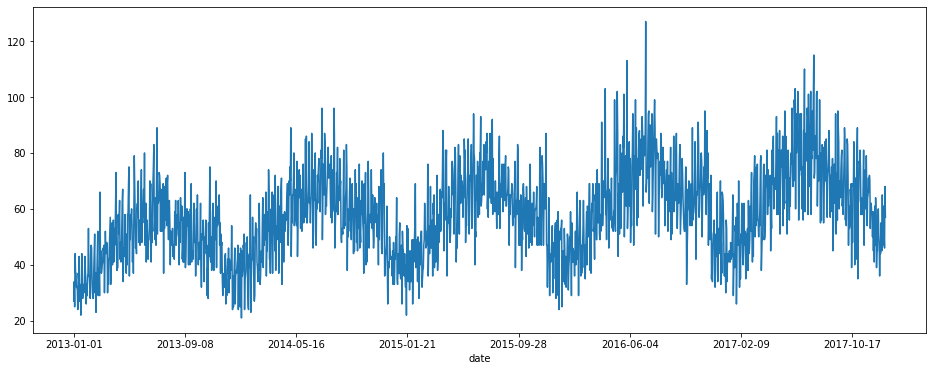

In [ ]:
#%% miramos cómo se la ve...
rcParams['figure.figsize'] = 16, 6
ventas.plot()    # toda

<AxesSubplot:xlabel='date'>

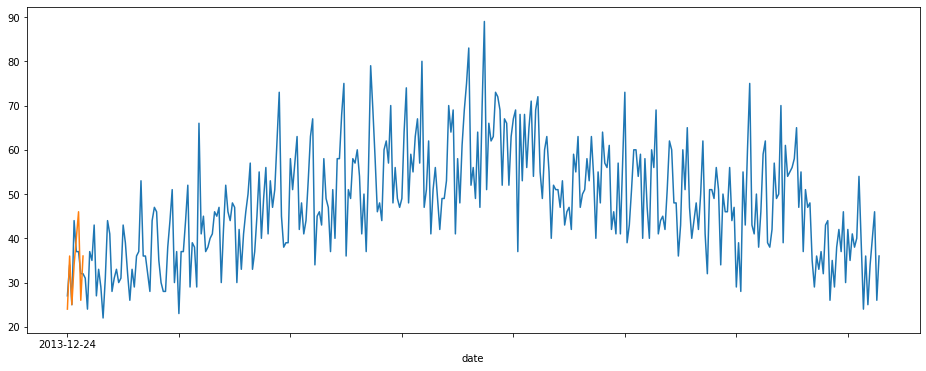

In [ ]:
ventas[:'2013-12-31'].plot()   # primer año

<AxesSubplot:xlabel='date'>

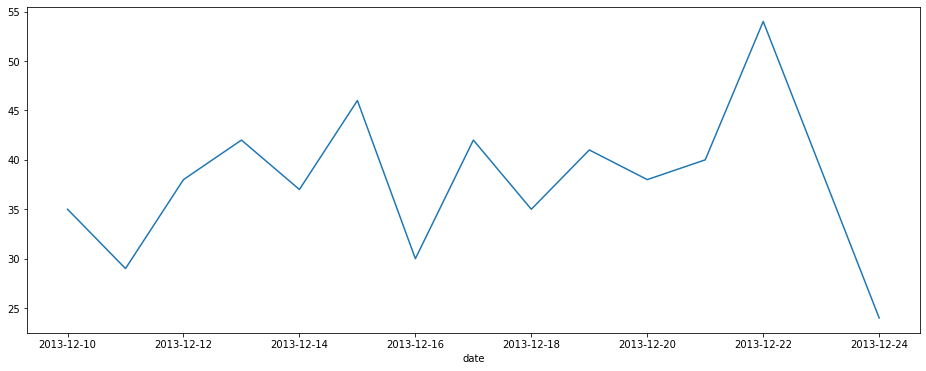

In [ ]:
ventas['2013-12-10':'2013-12-24'].plot()

In [ ]:
#%%    vemos si es estacionaria ->  test de Dickey-Fuller
    
dickey_fuller(ventas)     # DÉBILMENTE ESTACIONARIA
    



Resultado de la prueba Dickey-Fuller
------------------
Estadística de prueba	 -2.989960453051469
p-value			 0.035842664136794336
------------------
Valores críticos (la estadística de prueba debe ser MENOR)
Confianza 90%		-2.567624583142913 > -2.989960453051469... PASA: ES ESTACIONARIA
Confianza 95%		-2.8631452508003057 > -2.989960453051469... PASA: ES ESTACIONARIA
Confianza 99%		-3.4339840952648695 < -2.989960453051469... FALLA: NO ES ESTACIONARIA


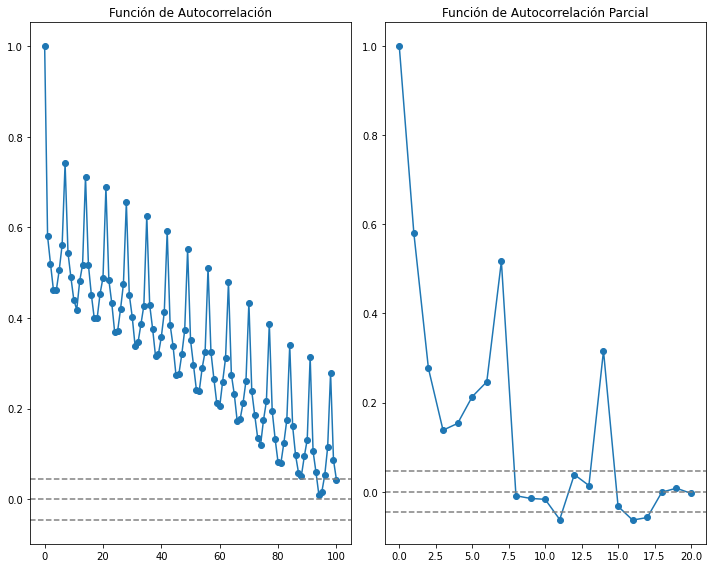

In [ ]:
#%%   miramos autocorrelación y autocorrelación parcial
    
autocor = sm_api.tsa.acf(ventas, nlags = 100)
parcial = sm_api.tsa.pacf(ventas, nlags = 20, method = 'ols')
    
rcParams['figure.figsize'] = 10, 8
    # Plot ACF:
plt.subplot(121)
plt.plot(autocor,"-o")
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ventas)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ventas)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación')
    
    # Plot PACF:
plt.subplot(122)
plt.plot(parcial,"-o")
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ventas)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ventas)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial')
plt.tight_layout()

In [ ]:
#%%   ADF Test: Indica cantidad diferenciaciones p/ 'estacionarizar' serie
    
dif = ndiffs(ventas, test = 'adf')
print(f'Cuántas veces hay que diferenciar la serie? {dif}')
    

Cuántas veces hay que diferenciar la serie? 0


In [ ]:
#%% ahora vamos a hacer un pronóstico sobre nuestra serie:
# usamos VALIDACIÓN CRUZADA FUERA DE TIEMPO
    
# creamos cjto de Training y Test, 80% training, 20% testing
# acá no se hace elección aleatoria de las mediciones porque hay q respetar
# el orden temporal
    
train = ventas[:'2016-12-31']   # 80% sobre el rango de fechas (training)
test = ventas['2017-01-01':]    # 20% para testeo
    

In [ ]:
#%%     ahora usamos TBATS: la bala de plata...
    
estimador = TBATS(seasonal_periods = [7., 365.25])   #, 
               # n_jobs = -1)           # https://pypi.org/project/tbats/
                # , use_arma_errors = False, use_box_cox = False)
    
# m cantidad de mediciones en un periodo: 7., 365.25 (mediciones diarias)

In [ ]:
model_tbats = estimador.fit(train)

In [ ]:
#%%   # 1 año = 365 steps con datos diarios, confianza 95%
    
pronostico_tbats, int_conf = model_tbats.forecast(steps = 365, confidence_level = 0.95) 

In [ ]:
 #%%
print(type(pronostico_tbats))     # es un nparray, hay que pasarlo a serie
tbats = pd.Series(pronostico_tbats)
tbats.index = test.index    # le ponemos las fechas de medición como índice
print(int_conf)
    
abajo = pd.Series(int_conf['lower_bound'])
arriba = pd.Series(int_conf['upper_bound'])
abajo.index = test.index
arriba.index = test.index

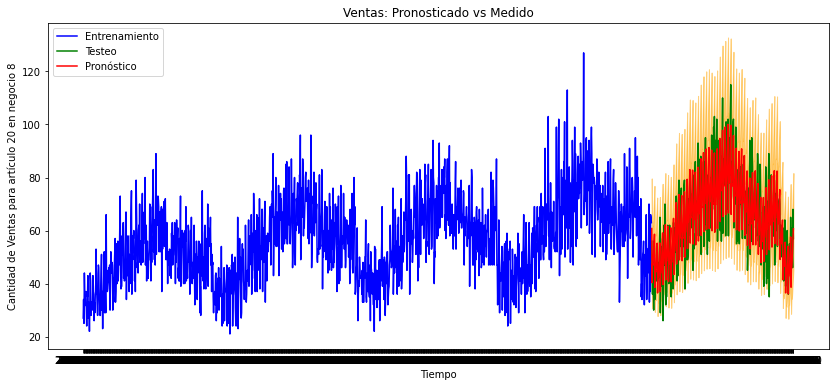

In [ ]:
   #%%     graficamos los valores medidos y los predichos...
    
rcParams['figure.figsize'] = 14, 6
plt.plot(train, c = 'blue', label = 'Entrenamiento')
plt.plot(test, c = 'green', label = 'Testeo')
plt.plot(tbats, c = 'red', label = 'Pronóstico')
plt.fill_between(abajo.index, abajo, arriba, color='orange', alpha=.5)
plt.title('Ventas: Pronosticado vs Medido')
plt.xlabel('Tiempo')
plt.ylabel(f'Cantidad de Ventas para artículo {articulo} en negocio {negocio}')
plt.legend(loc='upper left', fontsize=10)
plt.show()
    
    #  Qué tal?  Lindo, verdad? :-))
    

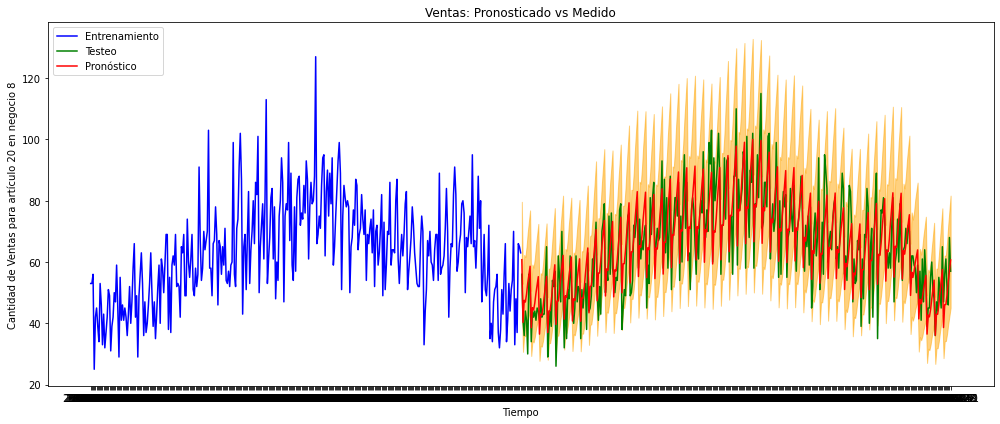

In [ ]:
   #%%   con más detalle...
    
plt.plot(train['2016-01-01':], c = 'blue', label = 'Entrenamiento')
plt.plot(test, c = 'green', label = 'Testeo')
plt.plot(tbats, c = 'red', label = 'Pronóstico')
plt.fill_between(abajo.index, abajo, arriba, color='orange', alpha=.5)
plt.title('Ventas: Pronosticado vs Medido')
plt.xlabel('Tiempo')
plt.ylabel(f'Cantidad de Ventas para artículo {articulo} en negocio {negocio}')
plt.legend(loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()
        

In [ ]:
 #%%   MIREMOS LOS RESULTADOS DEL MODELO
    # EJEMPLOS Y MÁS INFO: https://github.com/intive-DataScience/tbats
    
print('RESUMEN MODELO: ', model_tbats.summary())
    
    # Análisis de la serie temporal
print('Predicción muestra: ', model_tbats.y_hat) # predicción sobre muestra
print('Residuos: ', model_tbats.resid) # residuos en muestra
print('AIC:', model_tbats.aic)
    
    # Parámetros del modelo
print('Parámetro de suavizado: ', model_tbats.params.alpha)
print('Tendencia: ', model_tbats.params.beta)
print('Vector semilla: ', model_tbats.params.x0)
print('use_box_cox =', model_tbats.params.components.use_box_cox)
print('Armónicos (cantidad para c/estacionalidad): ', model_tbats.params.components.seasonal_harmonics)
    
    # Print mean absolute errors
print('MobileAverageError (en muestra)', np.mean(np.abs(model_tbats.resid)))
print('MAE (pronóstico)', np.mean(np.abs(pronostico_tbats - test)))

    # Print forecast confidence intervals
print('Calculado con intervalo de confianza:', int_conf['calculated_for_level'])

print('Cálculos válidos sólo cuando los errores tienen distribución NORMAL')
'''
print('Límite inferior:', int_conf['lower_bound'])
print('Pronóstico:', int_conf['mean'])
print('Límite superior:', int_conf['upper_bound'])
'''

RESUMEN MODELO:  Use Box-Cox: True
Use trend: False
Use damped trend: False
Seasonal periods: [  7.   365.25]
Seasonal harmonics [ 3 13]
ARMA errors (p, q): (1, 0)
Box-Cox Lambda 0.010138
Smoothing (Alpha): 0.023182
Seasonal Parameters (Gamma): [-0.0013194   0.00047175 -0.00196392 -0.0003128 ]
AR coefficients [-0.00196392]
MA coefficients []
Seed vector [ 3.86536161e+00 -1.31627840e-01 -1.16024504e-02  7.94011668e-02
 -3.03473275e-02  8.51530953e-02  4.74579021e-02 -2.40590093e-01
 -3.36581522e-02 -4.39272002e-02 -2.07292190e-02 -1.56261907e-02
  5.40467914e-03  1.56681782e-02  1.80590009e-02  1.29072683e-02
  1.07831277e-02  2.10011857e-02  6.02419251e-03 -1.88018538e-02
 -2.86622971e-02 -3.90309610e-02 -3.43803397e-02  1.21456124e-02
  9.52182556e-03  3.67712774e-02  2.01507668e-03  7.64944667e-03
 -1.10023935e-02 -1.29725780e-02 -1.71149094e-02 -4.24964118e-03
  2.46503871e-03  0.00000000e+00]

AIC 16614.557476
Predicción muestra:  [31.71420486 31.38783714 32.91960587 ... 49.7619341

"\nprint('Límite inferior:', int_conf['lower_bound'])\nprint('Pronóstico:', int_conf['mean'])\nprint('Límite superior:', int_conf['upper_bound'])\n"